# CSE251B Project Milestone Starter File

## Step 1: Import Dependencies:

In [16]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import random

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torch_geometric.data import Data, Batch
import tqdm

## Step 2: Load the Dataset

#### You need to describe in your own words what the dataset is about, and use mathematical language and formulate your prediction task on the submitted PDF file for Question 1 Problem A.

#### Here we are loading the dataset from the local directory. And answer Question 1 Problem B

In [17]:
train_npz = np.load('cse-251-b-2025/train.npz')
train_data = train_npz['data']
test_npz  = np.load('cse-251-b-2025/test_input.npz')
test_data  = test_npz['data']

In [18]:
print(train_data.shape, test_data.shape)

# Split once for later use
X_train = train_data[..., :50, :]
Y_train = train_data[:, 0, 50:, :2]

(10000, 50, 110, 6) (2100, 50, 50, 6)


In [19]:
def plot_heatmap(data, title=None, bins=5):
    plt.figure(figsize=(6, 6))

    x_max = data[..., 0].max()
    x_min = data[..., 0].min()
    y_max = data[..., 1].max()
    y_min = data[..., 1].min()

    plt.hist2d(data[:, 0], data[:, 1], bins=bins, cmap='hot')
    plt.xlim(x_min, x_max)
    plt.ylim(y_min, y_max)
    plt.title(title)
    plt.colorbar(label='Density')
    plt.xlabel('X-axis')
    plt.ylabel('Y-axis')
    plt.show()

In [20]:
xy_in = train_data[:, :, :50, :2].reshape(-1, 2)
# only find the x, y != 0
xy_in_not_0 = xy_in[(xy_in[:, 0] != 0) & (xy_in[:, 1] != 0)]

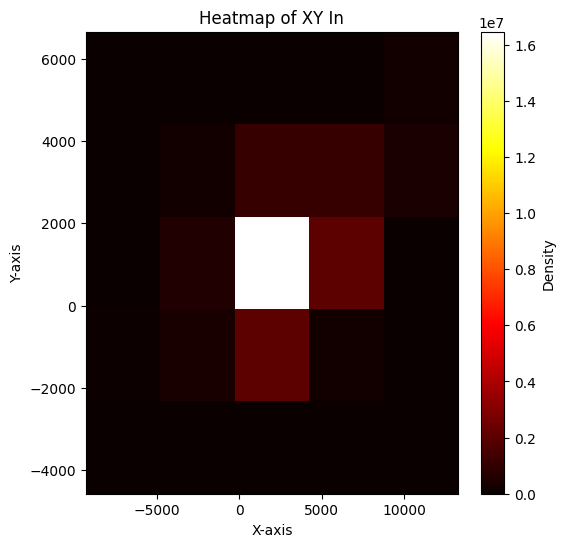

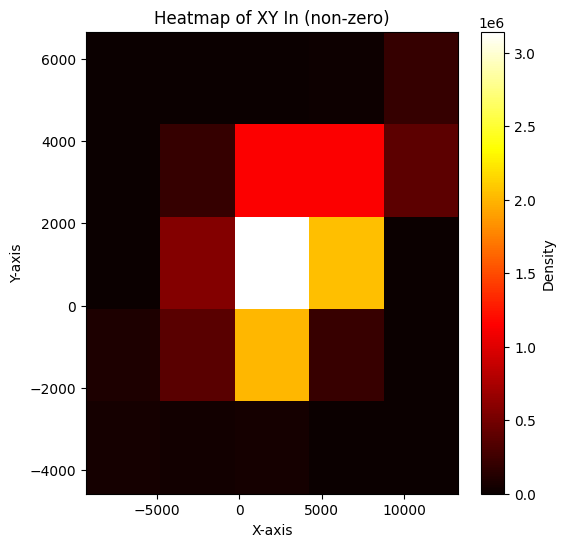

In [21]:
plot_heatmap(xy_in, title='Heatmap of XY In', bins=5)
plot_heatmap(xy_in_not_0, title='Heatmap of XY In (non-zero)', bins=5)

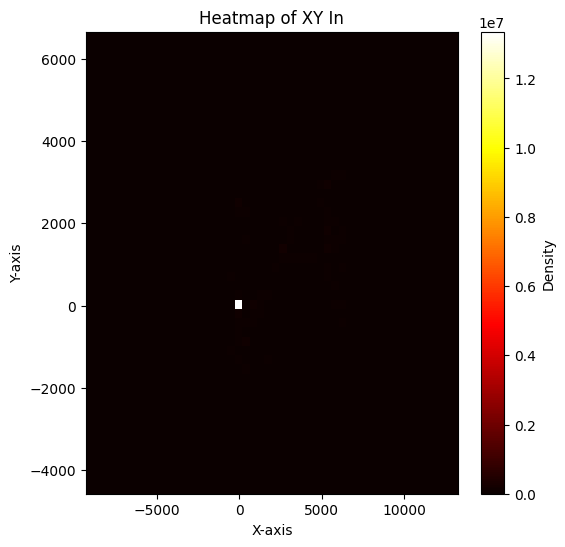

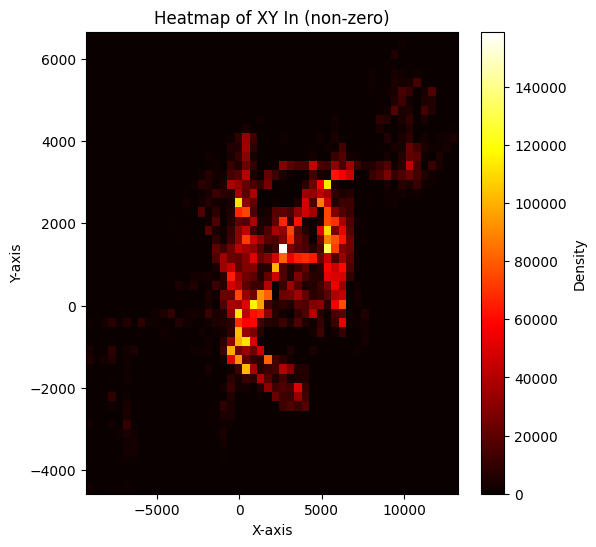

In [22]:
plot_heatmap(xy_in, title='Heatmap of XY In', bins=50)
plot_heatmap(xy_in_not_0, title='Heatmap of XY In (non-zero)', bins=50)

#### Try to play around with dataset for training and testing, make exploratory analysis on the dataset for bonus points(up to 2)

## Step 3: Setting up the Training and Testing

### Example Code:

In [23]:
class TrajectoryDatasetTrain(Dataset):
    def __init__(self, data, scale=10.0, augment=True):
        """
        data: Shape (N, 50, 110, 6) Training data
        scale: Scale for normalization (suggested to use 10.0 for Argoverse 2 data)
        augment: Whether to apply data augmentation (only for training)
        """
        self.data = data
        self.scale = scale
        self.augment = augment

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        scene = self.data[idx]
        # Getting 50 historical timestamps and 60 future timestamps
        hist = scene[:, :50, :].copy()    # (agents=50, time_seq=50, 6)
        future = torch.tensor(scene[0, 50:, :2].copy(), dtype=torch.float32)  # (60, 2)
        
        # Data augmentation(only for training)
        if self.augment:
            if np.random.rand() < 0.5:
                theta = np.random.uniform(-np.pi, np.pi)
                R = np.array([[np.cos(theta), -np.sin(theta)],
                              [np.sin(theta),  np.cos(theta)]], dtype=np.float32)
                # Rotate the historical trajectory and future trajectory
                hist[..., :2] = hist[..., :2] @ R
                hist[..., 2:4] = hist[..., 2:4] @ R
                future = future @ R
            if np.random.rand() < 0.5:
                hist[..., 0] *= -1
                hist[..., 2] *= -1
                future[:, 0] *= -1

        # Use the last timeframe of the historical trajectory as the origin
        origin = hist[0, 49, :2].copy()  # (2,)
        hist[..., :2] = hist[..., :2] - origin
        future = future - origin

        # Normalize the historical trajectory and future trajectory
        hist[..., :4] = hist[..., :4] / self.scale
        future = future / self.scale

        data_item = Data(
            x=torch.tensor(hist, dtype=torch.float32),
            y=future.type(torch.float32),
            origin=torch.tensor(origin, dtype=torch.float32).unsqueeze(0),
            scale=torch.tensor(self.scale, dtype=torch.float32),
        )

        return data_item
    

class TrajectoryDatasetTest(Dataset):
    def __init__(self, data, scale=10.0):
        """
        data: Shape (N, 50, 110, 6) Testing data
        scale: Scale for normalization (suggested to use 10.0 for Argoverse 2 data)
        """
        self.data = data
        self.scale = scale

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        # Testing data only contains historical trajectory
        scene = self.data[idx]  # (50, 50, 6)
        hist = scene.copy()
        
        origin = hist[0, 49, :2].copy()
        hist[..., :2] = hist[..., :2] - origin
        hist[..., :4] = hist[..., :4] / self.scale

        data_item = Data(
            x=torch.tensor(hist, dtype=torch.float32),
            origin=torch.tensor(origin, dtype=torch.float32).unsqueeze(0),
            scale=torch.tensor(self.scale, dtype=torch.float32),
        )
        return data_item

#### Answer Question related to Your Computational Platform and GPU for Question 2 Problem A

In [24]:
torch.manual_seed(251)
np.random.seed(42)

scale = 7.0

N = len(train_data)
val_size = int(0.1 * N)
train_size = N - val_size

train_dataset = TrajectoryDatasetTrain(train_data[:train_size], scale=scale, augment=True)
val_dataset = TrajectoryDatasetTrain(train_data[train_size:], scale=scale, augment=False)

train_dataloader = DataLoader(train_dataset, batch_size=32, shuffle=True, collate_fn=lambda x: Batch.from_data_list(x))
val_dataloader = DataLoader(val_dataset, batch_size=32, shuffle=False, collate_fn=lambda x: Batch.from_data_list(x))

# Set device for training speedup
if torch.backends.mps.is_available():
    device = torch.device('mps')
    print("Using Apple Silicon GPU")
elif torch.cuda.is_available():
    device = torch.device('cuda')
    print("Using CUDA GPU")
else:
    device = torch.device('cpu')

Using CUDA GPU


#### Your Model for Question 2 Problem B (Include your model architecture pictures and also can use some mathmatical equations to explain your model in your report)

In [25]:
class LinearRegressionModel(nn.Module):
    def __init__(self, input_dim=50 * 50 * 2, output_dim=60 * 2):
        super(LinearRegressionModel, self).__init__()
        self.linear = nn.Linear(input_dim, output_dim)

    def forward(self, data):
        x = data.x[..., :2] # (batch*50, 50, 2)
        x = x.reshape(-1, 50 * 50 * 2) # (batch, 5000)
        x = self.linear(x)
        return x.view(-1, 60, 2)

In [26]:
class MLP(nn.Module):
    def __init__(self, input_features, output_features):
        super(MLP, self).__init__()
        
        # Define the layers
        self.flatten = nn.Flatten()
        self.mlp = nn.Sequential(
            nn.Linear(input_features, 1024),
            nn.ReLU(),
            nn.Dropout(0.1),
            
            nn.Linear(1024, 512),
            nn.ReLU(),
            nn.Dropout(0.1),
            
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Dropout(0.1),
            
            nn.Linear(256, output_features)
        )
    
    def forward(self, data):
        x = data.x
        x = x[:, :, :, :2] # (batch, 50, 50, 2)
        x = x.reshape(-1, 50 * 50 * 6)
        x = self.mlp(x)
        return x.view(-1, 60, 2)

#### This Model will be covered during Week 6 Lecture (If you don't understand it for now, don't worry, we will cover it in the lecture, or you can ask in the office hours)

In [107]:
import math
class Attention(nn.Module):
    def __init__(self, hidden_dim, dropout=0.1):
        super(Attention, self).__init__()
        self.attn = nn.Linear(hidden_dim, 1)
        self.dropout = nn.Dropout(dropout)
        self.norm = nn.LayerNorm(hidden_dim)

    def forward(self, lstm_out):
        # lstm_out: (B, T, H)
        lstm_out = self.norm(lstm_out)  # normalize across feature dim
        scores = self.attn(lstm_out).squeeze(-1)  # (B, T)
        weights = torch.softmax(scores, dim=1).unsqueeze(-1)  # (B, T, 1)
        context = torch.sum(weights * lstm_out, dim=1)  # (B, H)
        context = self.dropout(context)  # apply dropout to attention output
        return context

class LSTMWithRelativeTimeAttention(nn.Module):
    def __init__(self, input_dim=6, hidden_dim=300, output_dim=60 * 2, seq_len=90, dropout=0.2):
        super(LSTMWithRelativeTimeAttention, self).__init__()
        self.seq_len = seq_len
        self.input_dim = input_dim + 1  # for relative time
        self.hidden_dim = hidden_dim

        self.lstm = nn.LSTM(self.input_dim, hidden_dim, batch_first=True)
        self.lstm_norm = nn.LayerNorm(hidden_dim)
        self.dropout = nn.Dropout(dropout)

        self.attn = Attention(hidden_dim, dropout=dropout)
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, data):
        x = data.x.view(-1, 50, 50, 6)  # (B, A, T, F)
        x = x[:, 0, :, :]  # Only ego agent: (B, T, F)

        B, T, F = x.shape
        rel_time = torch.linspace(0, 1, T, device=x.device).unsqueeze(0).unsqueeze(-1)  # (1, T, 1)
        rel_time = rel_time.expand(B, -1, -1)  # (B, T, 1)

        x = torch.cat([x, rel_time], dim=-1)  # (B, T, F+1)

        lstm_out, _ = self.lstm(x)  # (B, T, H)
        lstm_out = self.lstm_norm(lstm_out)  # normalize LSTM output
        lstm_out = self.dropout(lstm_out)    # apply dropout

        context = self.attn(lstm_out)  # (B, H)
        out = self.fc(context)  # (B, 120)
        return out.view(-1, 60, 2)  # (B, 60, 2)

#### Your Optimizer and Hyperparameters for Question 2 Problem A (Try to use different optimizers and hyperparameters for your model and see how it affects the performance of your model)

In [110]:
#model = LinearRegressionModel().to(device)
# model = MLP(50 * 50 * 6, 60 * 2).to(device)
model = LSTMWithRelativeTimeAttention().to(device)

optimizer = optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-4)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=20, gamma=0.25) # You can try different schedulers
early_stopping_patience = 125
best_val_loss = float('inf')
no_improvement = 0
criterion = nn.MSELoss()

#### Using the Simple Linear Regression Model for Question 2B and Visualize the validation loss(MAE) (Hint: You should adapt the code for training loss and try to draw graphs as specified in the project description)

In [111]:
for epoch in tqdm.tqdm(range(250), desc="Epoch", unit="epoch"):
    # ---- Training ----
    model.train()
    train_loss = 0
    for batch in train_dataloader:
        batch = batch.to(device)
        pred = model(batch)
        y = batch.y.view(batch.num_graphs, 60, 2)
        loss = criterion(pred, y)
        optimizer.zero_grad()
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 5.0)
        optimizer.step()
        train_loss += loss.item()
    
    # ---- Validation ----
    model.eval()
    val_loss = 0
    val_mae = 0
    val_mse = 0
    with torch.no_grad():
        for batch in val_dataloader:
            batch = batch.to(device)
            pred = model(batch)
            y = batch.y.view(batch.num_graphs, 60, 2)
            val_loss += criterion(pred, y).item()

            # show MAE and MSE with unnormalized data
            pred = pred * batch.scale.view(-1, 1, 1) + batch.origin.unsqueeze(1)
            y = y * batch.scale.view(-1, 1, 1) + batch.origin.unsqueeze(1)
            val_mae += nn.L1Loss()(pred, y).item()
            val_mse += nn.MSELoss()(pred, y).item()
    
    train_loss /= len(train_dataloader)
    val_loss /= len(val_dataloader)
    val_mae /= len(val_dataloader)
    val_mse /= len(val_dataloader)
    scheduler.step()
    # scheduler.step(val_loss)
    
    tqdm.tqdm.write(f"Epoch {epoch:03d} | Learning rate {optimizer.param_groups[0]['lr']:.6f} | train normalized MSE {train_loss:8.4f} | val normalized MSE {val_loss:8.4f}, | val MAE {val_mae:8.4f} | val MSE {val_mse:8.4f}")
    if val_loss < best_val_loss - 1e-3:
        best_val_loss = val_loss
        no_improvement = 0
        torch.save(model.state_dict(), "best_model.pt")
    else:
        no_improvement += 1
        if no_improvement >= early_stopping_patience:
            print("Early stop!")
            break

Epoch:   0%|                                                                                | 0/250 [00:00<?, ?epoch/s]C:\Users\dysr3\AppData\Local\Temp\ipykernel_27084\3713195397.py:30: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  future = future @ R
C:\Users\dysr3\AppData\Local\Temp\ipykernel_27084\3713195397.py:39: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  future = future - origin
Epoch:   0%|▎                                                                       | 1/250 [00:03<12:31,  3.02s/epoch]

Epoch 000 | Learning rate 0.001000 | train normalized MSE   0.9184 | val normalized MSE   0.4344, | val MAE   2.6223 | val MSE  21.2861


Epoch:   1%|▌                                                                       | 2/250 [00:05<12:01,  2.91s/epoch]

Epoch 001 | Learning rate 0.001000 | train normalized MSE   0.5119 | val normalized MSE   0.5458, | val MAE   3.0001 | val MSE  26.7428


Epoch:   1%|▊                                                                       | 3/250 [00:08<11:50,  2.88s/epoch]

Epoch 002 | Learning rate 0.001000 | train normalized MSE   0.4439 | val normalized MSE   0.3817, | val MAE   2.3968 | val MSE  18.7027


Epoch:   2%|█▏                                                                      | 4/250 [00:11<11:38,  2.84s/epoch]

Epoch 003 | Learning rate 0.001000 | train normalized MSE   0.4252 | val normalized MSE   0.3415, | val MAE   2.1671 | val MSE  16.7347


Epoch:   2%|█▍                                                                      | 5/250 [00:14<11:31,  2.82s/epoch]

Epoch 004 | Learning rate 0.001000 | train normalized MSE   0.3976 | val normalized MSE   0.3769, | val MAE   2.4450 | val MSE  18.4657


Epoch:   2%|█▋                                                                      | 6/250 [00:17<11:26,  2.81s/epoch]

Epoch 005 | Learning rate 0.001000 | train normalized MSE   0.3828 | val normalized MSE   0.3477, | val MAE   2.4729 | val MSE  17.0387


Epoch:   3%|██                                                                      | 7/250 [00:19<11:23,  2.81s/epoch]

Epoch 006 | Learning rate 0.001000 | train normalized MSE   0.3740 | val normalized MSE   0.3271, | val MAE   2.1914 | val MSE  16.0255


Epoch:   3%|██▎                                                                     | 8/250 [00:22<11:17,  2.80s/epoch]

Epoch 007 | Learning rate 0.001000 | train normalized MSE   0.3641 | val normalized MSE   0.3036, | val MAE   2.0957 | val MSE  14.8760


Epoch:   4%|██▌                                                                     | 9/250 [00:25<11:13,  2.80s/epoch]

Epoch 008 | Learning rate 0.001000 | train normalized MSE   0.3570 | val normalized MSE   0.3545, | val MAE   2.4603 | val MSE  17.3723


Epoch:   4%|██▊                                                                    | 10/250 [00:28<11:10,  2.79s/epoch]

Epoch 009 | Learning rate 0.001000 | train normalized MSE   0.3550 | val normalized MSE   0.3195, | val MAE   2.3140 | val MSE  15.6574


Epoch:   4%|███                                                                    | 11/250 [00:31<11:07,  2.79s/epoch]

Epoch 010 | Learning rate 0.001000 | train normalized MSE   0.3501 | val normalized MSE   0.3336, | val MAE   2.3512 | val MSE  16.3468


Epoch:   5%|███▍                                                                   | 12/250 [00:33<11:05,  2.79s/epoch]

Epoch 011 | Learning rate 0.001000 | train normalized MSE   0.3439 | val normalized MSE   0.3122, | val MAE   2.2115 | val MSE  15.2960


Epoch:   5%|███▋                                                                   | 13/250 [00:36<11:01,  2.79s/epoch]

Epoch 012 | Learning rate 0.001000 | train normalized MSE   0.3417 | val normalized MSE   0.3491, | val MAE   2.4319 | val MSE  17.1073


Epoch:   6%|███▉                                                                   | 14/250 [00:39<10:59,  2.79s/epoch]

Epoch 013 | Learning rate 0.001000 | train normalized MSE   0.3339 | val normalized MSE   0.3220, | val MAE   2.1269 | val MSE  15.7800


Epoch:   6%|████▎                                                                  | 15/250 [00:42<10:55,  2.79s/epoch]

Epoch 014 | Learning rate 0.001000 | train normalized MSE   0.3304 | val normalized MSE   0.3777, | val MAE   2.4024 | val MSE  18.5077


Epoch:   6%|████▌                                                                  | 16/250 [00:44<10:53,  2.79s/epoch]

Epoch 015 | Learning rate 0.001000 | train normalized MSE   0.3252 | val normalized MSE   0.2809, | val MAE   2.1259 | val MSE  13.7637


Epoch:   7%|████▊                                                                  | 17/250 [00:47<10:49,  2.79s/epoch]

Epoch 016 | Learning rate 0.001000 | train normalized MSE   0.3206 | val normalized MSE   0.2935, | val MAE   2.1938 | val MSE  14.3835


Epoch:   7%|█████                                                                  | 18/250 [00:50<10:46,  2.79s/epoch]

Epoch 017 | Learning rate 0.001000 | train normalized MSE   0.3195 | val normalized MSE   0.3414, | val MAE   2.3278 | val MSE  16.7276


Epoch:   8%|█████▍                                                                 | 19/250 [00:53<10:42,  2.78s/epoch]

Epoch 018 | Learning rate 0.001000 | train normalized MSE   0.3205 | val normalized MSE   0.2854, | val MAE   2.1045 | val MSE  13.9862


Epoch:   8%|█████▋                                                                 | 20/250 [00:56<10:41,  2.79s/epoch]

Epoch 019 | Learning rate 0.000250 | train normalized MSE   0.3141 | val normalized MSE   0.2882, | val MAE   2.0863 | val MSE  14.1200


Epoch:   8%|█████▉                                                                 | 21/250 [00:58<10:39,  2.79s/epoch]

Epoch 020 | Learning rate 0.000250 | train normalized MSE   0.2780 | val normalized MSE   0.2549, | val MAE   1.8493 | val MSE  12.4881


Epoch:   9%|██████▏                                                                | 22/250 [01:01<10:35,  2.79s/epoch]

Epoch 021 | Learning rate 0.000250 | train normalized MSE   0.2728 | val normalized MSE   0.2510, | val MAE   1.8301 | val MSE  12.2981


Epoch:   9%|██████▌                                                                | 23/250 [01:04<10:31,  2.78s/epoch]

Epoch 022 | Learning rate 0.000250 | train normalized MSE   0.2655 | val normalized MSE   0.2581, | val MAE   1.8956 | val MSE  12.6480


Epoch:  10%|██████▊                                                                | 24/250 [01:07<10:29,  2.79s/epoch]

Epoch 023 | Learning rate 0.000250 | train normalized MSE   0.2632 | val normalized MSE   0.2602, | val MAE   1.9253 | val MSE  12.7506


Epoch:  10%|███████                                                                | 25/250 [01:10<10:27,  2.79s/epoch]

Epoch 024 | Learning rate 0.000250 | train normalized MSE   0.2636 | val normalized MSE   0.2622, | val MAE   1.8580 | val MSE  12.8473


Epoch:  10%|███████▍                                                               | 26/250 [01:12<10:25,  2.79s/epoch]

Epoch 025 | Learning rate 0.000250 | train normalized MSE   0.2653 | val normalized MSE   0.2645, | val MAE   2.0182 | val MSE  12.9613


Epoch:  11%|███████▋                                                               | 27/250 [01:15<10:23,  2.80s/epoch]

Epoch 026 | Learning rate 0.000250 | train normalized MSE   0.2604 | val normalized MSE   0.2340, | val MAE   1.7963 | val MSE  11.4648


Epoch:  11%|███████▉                                                               | 28/250 [01:18<10:20,  2.80s/epoch]

Epoch 027 | Learning rate 0.000250 | train normalized MSE   0.2598 | val normalized MSE   0.2573, | val MAE   1.8397 | val MSE  12.6091


Epoch:  12%|████████▏                                                              | 29/250 [01:21<10:16,  2.79s/epoch]

Epoch 028 | Learning rate 0.000250 | train normalized MSE   0.2574 | val normalized MSE   0.2423, | val MAE   1.8186 | val MSE  11.8742


Epoch:  12%|████████▌                                                              | 30/250 [01:24<10:13,  2.79s/epoch]

Epoch 029 | Learning rate 0.000250 | train normalized MSE   0.2536 | val normalized MSE   0.2680, | val MAE   1.9410 | val MSE  13.1317


Epoch:  12%|████████▊                                                              | 31/250 [01:26<10:10,  2.79s/epoch]

Epoch 030 | Learning rate 0.000250 | train normalized MSE   0.2558 | val normalized MSE   0.2495, | val MAE   1.8910 | val MSE  12.2247


Epoch:  13%|█████████                                                              | 32/250 [01:29<10:07,  2.79s/epoch]

Epoch 031 | Learning rate 0.000250 | train normalized MSE   0.2539 | val normalized MSE   0.2182, | val MAE   1.7108 | val MSE  10.6924


Epoch:  13%|█████████▎                                                             | 33/250 [01:32<10:05,  2.79s/epoch]

Epoch 032 | Learning rate 0.000250 | train normalized MSE   0.2499 | val normalized MSE   0.2475, | val MAE   1.8273 | val MSE  12.1273


Epoch:  14%|█████████▋                                                             | 34/250 [01:35<10:02,  2.79s/epoch]

Epoch 033 | Learning rate 0.000250 | train normalized MSE   0.2496 | val normalized MSE   0.2306, | val MAE   1.6945 | val MSE  11.2997


Epoch:  14%|█████████▉                                                             | 35/250 [01:37<09:59,  2.79s/epoch]

Epoch 034 | Learning rate 0.000250 | train normalized MSE   0.2493 | val normalized MSE   0.2475, | val MAE   1.9849 | val MSE  12.1271


Epoch:  14%|██████████▏                                                            | 36/250 [01:40<09:56,  2.79s/epoch]

Epoch 035 | Learning rate 0.000250 | train normalized MSE   0.2488 | val normalized MSE   0.2456, | val MAE   1.7762 | val MSE  12.0350


Epoch:  15%|██████████▌                                                            | 37/250 [01:43<09:53,  2.79s/epoch]

Epoch 036 | Learning rate 0.000250 | train normalized MSE   0.2496 | val normalized MSE   0.2650, | val MAE   1.9601 | val MSE  12.9846


Epoch:  15%|██████████▊                                                            | 38/250 [01:46<09:51,  2.79s/epoch]

Epoch 037 | Learning rate 0.000250 | train normalized MSE   0.2465 | val normalized MSE   0.2391, | val MAE   1.7802 | val MSE  11.7139


Epoch:  16%|███████████                                                            | 39/250 [01:49<09:48,  2.79s/epoch]

Epoch 038 | Learning rate 0.000250 | train normalized MSE   0.2513 | val normalized MSE   0.2367, | val MAE   1.7942 | val MSE  11.6006


Epoch:  16%|███████████▎                                                           | 40/250 [01:51<09:45,  2.79s/epoch]

Epoch 039 | Learning rate 0.000063 | train normalized MSE   0.2484 | val normalized MSE   0.2444, | val MAE   1.8681 | val MSE  11.9752


Epoch:  16%|███████████▋                                                           | 41/250 [01:54<09:42,  2.79s/epoch]

Epoch 040 | Learning rate 0.000063 | train normalized MSE   0.2339 | val normalized MSE   0.2354, | val MAE   1.7381 | val MSE  11.5368


Epoch:  17%|███████████▉                                                           | 42/250 [01:57<09:40,  2.79s/epoch]

Epoch 041 | Learning rate 0.000063 | train normalized MSE   0.2324 | val normalized MSE   0.2197, | val MAE   1.6964 | val MSE  10.7631


Epoch:  17%|████████████▏                                                          | 43/250 [02:00<09:38,  2.79s/epoch]

Epoch 042 | Learning rate 0.000063 | train normalized MSE   0.2311 | val normalized MSE   0.2257, | val MAE   1.6857 | val MSE  11.0575


Epoch:  18%|████████████▍                                                          | 44/250 [02:03<09:36,  2.80s/epoch]

Epoch 043 | Learning rate 0.000063 | train normalized MSE   0.2345 | val normalized MSE   0.2077, | val MAE   1.5834 | val MSE  10.1787


Epoch:  18%|████████████▊                                                          | 45/250 [02:05<09:32,  2.79s/epoch]

Epoch 044 | Learning rate 0.000063 | train normalized MSE   0.2312 | val normalized MSE   0.2249, | val MAE   1.6784 | val MSE  11.0188


Epoch:  18%|█████████████                                                          | 46/250 [02:08<09:29,  2.79s/epoch]

Epoch 045 | Learning rate 0.000063 | train normalized MSE   0.2334 | val normalized MSE   0.2198, | val MAE   1.6621 | val MSE  10.7720


Epoch:  19%|█████████████▎                                                         | 47/250 [02:11<09:26,  2.79s/epoch]

Epoch 046 | Learning rate 0.000063 | train normalized MSE   0.2292 | val normalized MSE   0.2273, | val MAE   1.7030 | val MSE  11.1376


Epoch:  19%|█████████████▋                                                         | 48/250 [02:14<09:25,  2.80s/epoch]

Epoch 047 | Learning rate 0.000063 | train normalized MSE   0.2314 | val normalized MSE   0.2207, | val MAE   1.6481 | val MSE  10.8133


Epoch:  20%|█████████████▉                                                         | 49/250 [02:17<09:21,  2.80s/epoch]

Epoch 048 | Learning rate 0.000063 | train normalized MSE   0.2293 | val normalized MSE   0.2172, | val MAE   1.6317 | val MSE  10.6449


Epoch:  20%|██████████████▏                                                        | 50/250 [02:19<09:26,  2.83s/epoch]

Epoch 049 | Learning rate 0.000063 | train normalized MSE   0.2298 | val normalized MSE   0.2161, | val MAE   1.6342 | val MSE  10.5878


Epoch:  20%|██████████████▍                                                        | 51/250 [02:22<09:21,  2.82s/epoch]

Epoch 050 | Learning rate 0.000063 | train normalized MSE   0.2288 | val normalized MSE   0.2227, | val MAE   1.6583 | val MSE  10.9137


Epoch:  21%|██████████████▊                                                        | 52/250 [02:25<09:17,  2.81s/epoch]

Epoch 051 | Learning rate 0.000063 | train normalized MSE   0.2337 | val normalized MSE   0.2268, | val MAE   1.7030 | val MSE  11.1133


Epoch:  21%|███████████████                                                        | 53/250 [02:28<09:12,  2.81s/epoch]

Epoch 052 | Learning rate 0.000063 | train normalized MSE   0.2267 | val normalized MSE   0.2216, | val MAE   1.6637 | val MSE  10.8584


Epoch:  22%|███████████████▎                                                       | 54/250 [02:31<09:10,  2.81s/epoch]

Epoch 053 | Learning rate 0.000063 | train normalized MSE   0.2252 | val normalized MSE   0.2275, | val MAE   1.7225 | val MSE  11.1470


Epoch:  22%|███████████████▌                                                       | 55/250 [02:34<09:11,  2.83s/epoch]

Epoch 054 | Learning rate 0.000063 | train normalized MSE   0.2272 | val normalized MSE   0.2325, | val MAE   1.7164 | val MSE  11.3919


Epoch:  22%|███████████████▉                                                       | 56/250 [02:36<09:06,  2.82s/epoch]

Epoch 055 | Learning rate 0.000063 | train normalized MSE   0.2276 | val normalized MSE   0.2196, | val MAE   1.6672 | val MSE  10.7589


Epoch:  23%|████████████████▏                                                      | 57/250 [02:39<09:00,  2.80s/epoch]

Epoch 056 | Learning rate 0.000063 | train normalized MSE   0.2260 | val normalized MSE   0.2268, | val MAE   1.7222 | val MSE  11.1140


Epoch:  23%|████████████████▍                                                      | 58/250 [02:42<08:57,  2.80s/epoch]

Epoch 057 | Learning rate 0.000063 | train normalized MSE   0.2261 | val normalized MSE   0.2237, | val MAE   1.6730 | val MSE  10.9592


Epoch:  24%|████████████████▊                                                      | 59/250 [02:45<08:54,  2.80s/epoch]

Epoch 058 | Learning rate 0.000063 | train normalized MSE   0.2259 | val normalized MSE   0.2102, | val MAE   1.5796 | val MSE  10.3018


Epoch:  24%|█████████████████                                                      | 60/250 [02:47<08:50,  2.79s/epoch]

Epoch 059 | Learning rate 0.000016 | train normalized MSE   0.2265 | val normalized MSE   0.2260, | val MAE   1.7021 | val MSE  11.0750


Epoch:  24%|█████████████████▎                                                     | 61/250 [02:50<08:46,  2.78s/epoch]

Epoch 060 | Learning rate 0.000016 | train normalized MSE   0.2224 | val normalized MSE   0.2196, | val MAE   1.6266 | val MSE  10.7586


Epoch:  25%|█████████████████▌                                                     | 62/250 [02:53<08:43,  2.78s/epoch]

Epoch 061 | Learning rate 0.000016 | train normalized MSE   0.2223 | val normalized MSE   0.2234, | val MAE   1.6438 | val MSE  10.9487


Epoch:  25%|█████████████████▉                                                     | 63/250 [02:56<08:38,  2.77s/epoch]

Epoch 062 | Learning rate 0.000016 | train normalized MSE   0.2240 | val normalized MSE   0.2198, | val MAE   1.6375 | val MSE  10.7702


Epoch:  26%|██████████████████▏                                                    | 64/250 [02:59<08:35,  2.77s/epoch]

Epoch 063 | Learning rate 0.000016 | train normalized MSE   0.2241 | val normalized MSE   0.2242, | val MAE   1.6632 | val MSE  10.9848


Epoch:  26%|██████████████████▍                                                    | 65/250 [03:01<08:32,  2.77s/epoch]

Epoch 064 | Learning rate 0.000016 | train normalized MSE   0.2245 | val normalized MSE   0.2149, | val MAE   1.6176 | val MSE  10.5296


Epoch:  26%|██████████████████▋                                                    | 66/250 [03:04<08:28,  2.76s/epoch]

Epoch 065 | Learning rate 0.000016 | train normalized MSE   0.2216 | val normalized MSE   0.2131, | val MAE   1.6203 | val MSE  10.4399


Epoch:  27%|███████████████████                                                    | 67/250 [03:07<08:24,  2.75s/epoch]

Epoch 066 | Learning rate 0.000016 | train normalized MSE   0.2226 | val normalized MSE   0.2287, | val MAE   1.7008 | val MSE  11.2078


Epoch:  27%|███████████████████▎                                                   | 68/250 [03:10<08:20,  2.75s/epoch]

Epoch 067 | Learning rate 0.000016 | train normalized MSE   0.2203 | val normalized MSE   0.2199, | val MAE   1.6353 | val MSE  10.7770


Epoch:  28%|███████████████████▌                                                   | 69/250 [03:12<08:15,  2.74s/epoch]

Epoch 068 | Learning rate 0.000016 | train normalized MSE   0.2233 | val normalized MSE   0.2193, | val MAE   1.6395 | val MSE  10.7445


Epoch:  28%|███████████████████▉                                                   | 70/250 [03:15<08:13,  2.74s/epoch]

Epoch 069 | Learning rate 0.000016 | train normalized MSE   0.2196 | val normalized MSE   0.2206, | val MAE   1.6300 | val MSE  10.8085


Epoch:  28%|████████████████████▏                                                  | 71/250 [03:18<08:13,  2.76s/epoch]

Epoch 070 | Learning rate 0.000016 | train normalized MSE   0.2224 | val normalized MSE   0.2158, | val MAE   1.6061 | val MSE  10.5755


Epoch:  29%|████████████████████▍                                                  | 72/250 [03:21<08:11,  2.76s/epoch]

Epoch 071 | Learning rate 0.000016 | train normalized MSE   0.2230 | val normalized MSE   0.2286, | val MAE   1.6947 | val MSE  11.2033


Epoch:  29%|████████████████████▋                                                  | 73/250 [03:23<08:06,  2.75s/epoch]

Epoch 072 | Learning rate 0.000016 | train normalized MSE   0.2210 | val normalized MSE   0.2180, | val MAE   1.6471 | val MSE  10.6802


Epoch:  30%|█████████████████████                                                  | 74/250 [03:26<08:01,  2.74s/epoch]

Epoch 073 | Learning rate 0.000016 | train normalized MSE   0.2197 | val normalized MSE   0.2248, | val MAE   1.6673 | val MSE  11.0128


Epoch:  30%|█████████████████████▎                                                 | 75/250 [03:29<07:59,  2.74s/epoch]

Epoch 074 | Learning rate 0.000016 | train normalized MSE   0.2198 | val normalized MSE   0.2130, | val MAE   1.5859 | val MSE  10.4377


Epoch:  30%|█████████████████████▌                                                 | 76/250 [03:31<07:58,  2.75s/epoch]

Epoch 075 | Learning rate 0.000016 | train normalized MSE   0.2236 | val normalized MSE   0.2167, | val MAE   1.6261 | val MSE  10.6170


Epoch:  31%|█████████████████████▊                                                 | 77/250 [03:34<07:56,  2.75s/epoch]

Epoch 076 | Learning rate 0.000016 | train normalized MSE   0.2204 | val normalized MSE   0.2199, | val MAE   1.6365 | val MSE  10.7752


Epoch:  31%|██████████████████████▏                                                | 78/250 [03:37<07:53,  2.75s/epoch]

Epoch 077 | Learning rate 0.000016 | train normalized MSE   0.2213 | val normalized MSE   0.2120, | val MAE   1.5889 | val MSE  10.3865


Epoch:  32%|██████████████████████▍                                                | 79/250 [03:40<07:53,  2.77s/epoch]

Epoch 078 | Learning rate 0.000016 | train normalized MSE   0.2182 | val normalized MSE   0.2239, | val MAE   1.6599 | val MSE  10.9717


Epoch:  32%|██████████████████████▋                                                | 80/250 [03:43<07:50,  2.77s/epoch]

Epoch 079 | Learning rate 0.000004 | train normalized MSE   0.2211 | val normalized MSE   0.2174, | val MAE   1.6438 | val MSE  10.6535


Epoch:  32%|███████████████████████                                                | 81/250 [03:45<07:47,  2.77s/epoch]

Epoch 080 | Learning rate 0.000004 | train normalized MSE   0.2196 | val normalized MSE   0.2177, | val MAE   1.6238 | val MSE  10.6683


Epoch:  33%|███████████████████████▎                                               | 82/250 [03:48<07:43,  2.76s/epoch]

Epoch 081 | Learning rate 0.000004 | train normalized MSE   0.2216 | val normalized MSE   0.2202, | val MAE   1.6354 | val MSE  10.7886


Epoch:  33%|███████████████████████▌                                               | 83/250 [03:51<07:38,  2.74s/epoch]

Epoch 082 | Learning rate 0.000004 | train normalized MSE   0.2195 | val normalized MSE   0.2137, | val MAE   1.5915 | val MSE  10.4695


Epoch:  34%|███████████████████████▊                                               | 84/250 [03:54<07:34,  2.74s/epoch]

Epoch 083 | Learning rate 0.000004 | train normalized MSE   0.2173 | val normalized MSE   0.2145, | val MAE   1.5975 | val MSE  10.5088


Epoch:  34%|████████████████████████▏                                              | 85/250 [03:56<07:34,  2.75s/epoch]

Epoch 084 | Learning rate 0.000004 | train normalized MSE   0.2189 | val normalized MSE   0.2154, | val MAE   1.6001 | val MSE  10.5527


Epoch:  34%|████████████████████████▍                                              | 86/250 [03:59<07:31,  2.75s/epoch]

Epoch 085 | Learning rate 0.000004 | train normalized MSE   0.2184 | val normalized MSE   0.2171, | val MAE   1.6146 | val MSE  10.6377


Epoch:  35%|████████████████████████▋                                              | 87/250 [04:02<07:29,  2.75s/epoch]

Epoch 086 | Learning rate 0.000004 | train normalized MSE   0.2188 | val normalized MSE   0.2176, | val MAE   1.6123 | val MSE  10.6629


Epoch:  35%|████████████████████████▉                                              | 88/250 [04:05<07:35,  2.81s/epoch]

Epoch 087 | Learning rate 0.000004 | train normalized MSE   0.2175 | val normalized MSE   0.2163, | val MAE   1.6113 | val MSE  10.6010


Epoch:  36%|█████████████████████████▎                                             | 89/250 [04:08<07:46,  2.90s/epoch]

Epoch 088 | Learning rate 0.000004 | train normalized MSE   0.2190 | val normalized MSE   0.2166, | val MAE   1.6154 | val MSE  10.6143


Epoch:  36%|█████████████████████████▌                                             | 90/250 [04:11<07:36,  2.85s/epoch]

Epoch 089 | Learning rate 0.000004 | train normalized MSE   0.2210 | val normalized MSE   0.2151, | val MAE   1.5989 | val MSE  10.5391


Epoch:  36%|█████████████████████████▊                                             | 91/250 [04:13<07:28,  2.82s/epoch]

Epoch 090 | Learning rate 0.000004 | train normalized MSE   0.2206 | val normalized MSE   0.2195, | val MAE   1.6311 | val MSE  10.7542


Epoch:  37%|██████████████████████████▏                                            | 92/250 [04:16<07:20,  2.78s/epoch]

Epoch 091 | Learning rate 0.000004 | train normalized MSE   0.2176 | val normalized MSE   0.2153, | val MAE   1.6083 | val MSE  10.5519


Epoch:  37%|██████████████████████████▍                                            | 93/250 [04:19<07:14,  2.77s/epoch]

Epoch 092 | Learning rate 0.000004 | train normalized MSE   0.2180 | val normalized MSE   0.2136, | val MAE   1.6084 | val MSE  10.4666


Epoch:  38%|██████████████████████████▋                                            | 94/250 [04:22<07:11,  2.76s/epoch]

Epoch 093 | Learning rate 0.000004 | train normalized MSE   0.2194 | val normalized MSE   0.2151, | val MAE   1.6091 | val MSE  10.5414


Epoch:  38%|██████████████████████████▉                                            | 95/250 [04:24<07:09,  2.77s/epoch]

Epoch 094 | Learning rate 0.000004 | train normalized MSE   0.2196 | val normalized MSE   0.2138, | val MAE   1.5904 | val MSE  10.4783


Epoch:  38%|███████████████████████████▎                                           | 96/250 [04:27<07:04,  2.76s/epoch]

Epoch 095 | Learning rate 0.000004 | train normalized MSE   0.2188 | val normalized MSE   0.2175, | val MAE   1.6195 | val MSE  10.6575


Epoch:  39%|███████████████████████████▌                                           | 97/250 [04:30<07:00,  2.75s/epoch]

Epoch 096 | Learning rate 0.000004 | train normalized MSE   0.2187 | val normalized MSE   0.2142, | val MAE   1.5945 | val MSE  10.4975


Epoch:  39%|███████████████████████████▊                                           | 98/250 [04:33<07:07,  2.81s/epoch]

Epoch 097 | Learning rate 0.000004 | train normalized MSE   0.2185 | val normalized MSE   0.2159, | val MAE   1.6164 | val MSE  10.5787


Epoch:  40%|████████████████████████████                                           | 99/250 [04:35<07:00,  2.79s/epoch]

Epoch 098 | Learning rate 0.000004 | train normalized MSE   0.2223 | val normalized MSE   0.2176, | val MAE   1.6143 | val MSE  10.6639


Epoch:  40%|████████████████████████████                                          | 100/250 [04:38<06:58,  2.79s/epoch]

Epoch 099 | Learning rate 0.000001 | train normalized MSE   0.2214 | val normalized MSE   0.2144, | val MAE   1.5967 | val MSE  10.5073


Epoch:  40%|████████████████████████████▎                                         | 101/250 [04:41<06:52,  2.77s/epoch]

Epoch 100 | Learning rate 0.000001 | train normalized MSE   0.2184 | val normalized MSE   0.2152, | val MAE   1.5994 | val MSE  10.5446


Epoch:  41%|████████████████████████████▌                                         | 102/250 [04:44<06:48,  2.76s/epoch]

Epoch 101 | Learning rate 0.000001 | train normalized MSE   0.2178 | val normalized MSE   0.2152, | val MAE   1.5978 | val MSE  10.5425


Epoch:  41%|████████████████████████████▊                                         | 103/250 [04:46<06:45,  2.76s/epoch]

Epoch 102 | Learning rate 0.000001 | train normalized MSE   0.2187 | val normalized MSE   0.2154, | val MAE   1.6039 | val MSE  10.5556


Epoch:  42%|█████████████████████████████                                         | 104/250 [04:49<06:42,  2.76s/epoch]

Epoch 103 | Learning rate 0.000001 | train normalized MSE   0.2167 | val normalized MSE   0.2150, | val MAE   1.5995 | val MSE  10.5351


Epoch:  42%|█████████████████████████████▍                                        | 105/250 [04:52<06:38,  2.75s/epoch]

Epoch 104 | Learning rate 0.000001 | train normalized MSE   0.2179 | val normalized MSE   0.2149, | val MAE   1.6005 | val MSE  10.5307


Epoch:  42%|█████████████████████████████▋                                        | 106/250 [04:55<06:36,  2.75s/epoch]

Epoch 105 | Learning rate 0.000001 | train normalized MSE   0.2183 | val normalized MSE   0.2152, | val MAE   1.6030 | val MSE  10.5439


Epoch:  43%|█████████████████████████████▉                                        | 107/250 [04:57<06:34,  2.76s/epoch]

Epoch 106 | Learning rate 0.000001 | train normalized MSE   0.2178 | val normalized MSE   0.2153, | val MAE   1.6031 | val MSE  10.5512


Epoch:  43%|██████████████████████████████▏                                       | 108/250 [05:00<06:28,  2.73s/epoch]

Epoch 107 | Learning rate 0.000001 | train normalized MSE   0.2184 | val normalized MSE   0.2149, | val MAE   1.6019 | val MSE  10.5307


Epoch:  44%|██████████████████████████████▌                                       | 109/250 [05:03<06:25,  2.73s/epoch]

Epoch 108 | Learning rate 0.000001 | train normalized MSE   0.2191 | val normalized MSE   0.2156, | val MAE   1.6072 | val MSE  10.5643


Epoch:  44%|██████████████████████████████▊                                       | 110/250 [05:06<06:21,  2.72s/epoch]

Epoch 109 | Learning rate 0.000001 | train normalized MSE   0.2183 | val normalized MSE   0.2156, | val MAE   1.6089 | val MSE  10.5621


Epoch:  44%|███████████████████████████████                                       | 111/250 [05:08<06:17,  2.72s/epoch]

Epoch 110 | Learning rate 0.000001 | train normalized MSE   0.2198 | val normalized MSE   0.2159, | val MAE   1.6083 | val MSE  10.5773


Epoch:  45%|███████████████████████████████▎                                      | 112/250 [05:11<06:13,  2.71s/epoch]

Epoch 111 | Learning rate 0.000001 | train normalized MSE   0.2182 | val normalized MSE   0.2154, | val MAE   1.6018 | val MSE  10.5542


Epoch:  45%|███████████████████████████████▋                                      | 113/250 [05:14<06:11,  2.71s/epoch]

Epoch 112 | Learning rate 0.000001 | train normalized MSE   0.2190 | val normalized MSE   0.2148, | val MAE   1.6013 | val MSE  10.5264


Epoch:  46%|███████████████████████████████▉                                      | 114/250 [05:16<06:07,  2.71s/epoch]

Epoch 113 | Learning rate 0.000001 | train normalized MSE   0.2202 | val normalized MSE   0.2144, | val MAE   1.5953 | val MSE  10.5073


Epoch:  46%|████████████████████████████████▏                                     | 115/250 [05:19<06:05,  2.70s/epoch]

Epoch 114 | Learning rate 0.000001 | train normalized MSE   0.2186 | val normalized MSE   0.2144, | val MAE   1.5954 | val MSE  10.5067


Epoch:  46%|████████████████████████████████▍                                     | 116/250 [05:22<06:04,  2.72s/epoch]

Epoch 115 | Learning rate 0.000001 | train normalized MSE   0.2219 | val normalized MSE   0.2143, | val MAE   1.5946 | val MSE  10.5030


Epoch:  47%|████████████████████████████████▊                                     | 117/250 [05:25<06:01,  2.72s/epoch]

Epoch 116 | Learning rate 0.000001 | train normalized MSE   0.2186 | val normalized MSE   0.2149, | val MAE   1.6025 | val MSE  10.5312


Epoch:  47%|█████████████████████████████████                                     | 118/250 [05:27<05:59,  2.72s/epoch]

Epoch 117 | Learning rate 0.000001 | train normalized MSE   0.2190 | val normalized MSE   0.2155, | val MAE   1.6029 | val MSE  10.5604


Epoch:  48%|█████████████████████████████████▎                                    | 119/250 [05:30<05:58,  2.73s/epoch]

Epoch 118 | Learning rate 0.000001 | train normalized MSE   0.2165 | val normalized MSE   0.2152, | val MAE   1.6020 | val MSE  10.5465


Epoch:  48%|█████████████████████████████████▌                                    | 120/250 [05:33<05:55,  2.73s/epoch]

Epoch 119 | Learning rate 0.000000 | train normalized MSE   0.2190 | val normalized MSE   0.2155, | val MAE   1.6035 | val MSE  10.5584


Epoch:  48%|█████████████████████████████████▉                                    | 121/250 [05:36<05:51,  2.72s/epoch]

Epoch 120 | Learning rate 0.000000 | train normalized MSE   0.2213 | val normalized MSE   0.2156, | val MAE   1.6050 | val MSE  10.5640


Epoch:  49%|██████████████████████████████████▏                                   | 122/250 [05:38<05:50,  2.74s/epoch]

Epoch 121 | Learning rate 0.000000 | train normalized MSE   0.2189 | val normalized MSE   0.2157, | val MAE   1.6041 | val MSE  10.5688


Epoch:  49%|██████████████████████████████████▍                                   | 123/250 [05:41<05:47,  2.74s/epoch]

Epoch 122 | Learning rate 0.000000 | train normalized MSE   0.2163 | val normalized MSE   0.2157, | val MAE   1.6041 | val MSE  10.5674


Epoch:  50%|██████████████████████████████████▋                                   | 124/250 [05:44<05:47,  2.76s/epoch]

Epoch 123 | Learning rate 0.000000 | train normalized MSE   0.2174 | val normalized MSE   0.2155, | val MAE   1.6040 | val MSE  10.5589


Epoch:  50%|███████████████████████████████████                                   | 125/250 [05:47<05:44,  2.75s/epoch]

Epoch 124 | Learning rate 0.000000 | train normalized MSE   0.2220 | val normalized MSE   0.2154, | val MAE   1.6041 | val MSE  10.5544


Epoch:  50%|███████████████████████████████████▎                                  | 126/250 [05:49<05:40,  2.75s/epoch]

Epoch 125 | Learning rate 0.000000 | train normalized MSE   0.2208 | val normalized MSE   0.2155, | val MAE   1.6045 | val MSE  10.5605


Epoch:  51%|███████████████████████████████████▌                                  | 127/250 [05:52<05:38,  2.75s/epoch]

Epoch 126 | Learning rate 0.000000 | train normalized MSE   0.2182 | val normalized MSE   0.2156, | val MAE   1.6038 | val MSE  10.5652


Epoch:  51%|███████████████████████████████████▊                                  | 128/250 [05:55<05:35,  2.75s/epoch]

Epoch 127 | Learning rate 0.000000 | train normalized MSE   0.2204 | val normalized MSE   0.2156, | val MAE   1.6043 | val MSE  10.5651


Epoch:  52%|████████████████████████████████████                                  | 129/250 [05:58<05:30,  2.73s/epoch]

Epoch 128 | Learning rate 0.000000 | train normalized MSE   0.2176 | val normalized MSE   0.2157, | val MAE   1.6042 | val MSE  10.5698


Epoch:  52%|████████████████████████████████████▍                                 | 130/250 [06:00<05:28,  2.74s/epoch]

Epoch 129 | Learning rate 0.000000 | train normalized MSE   0.2182 | val normalized MSE   0.2156, | val MAE   1.6038 | val MSE  10.5662


Epoch:  52%|████████████████████████████████████▋                                 | 131/250 [06:03<05:26,  2.75s/epoch]

Epoch 130 | Learning rate 0.000000 | train normalized MSE   0.2187 | val normalized MSE   0.2154, | val MAE   1.6025 | val MSE  10.5562


Epoch:  53%|████████████████████████████████████▉                                 | 132/250 [06:06<05:24,  2.75s/epoch]

Epoch 131 | Learning rate 0.000000 | train normalized MSE   0.2192 | val normalized MSE   0.2156, | val MAE   1.6033 | val MSE  10.5633


Epoch:  53%|█████████████████████████████████████▏                                | 133/250 [06:09<05:21,  2.75s/epoch]

Epoch 132 | Learning rate 0.000000 | train normalized MSE   0.2177 | val normalized MSE   0.2156, | val MAE   1.6044 | val MSE  10.5620


Epoch:  54%|█████████████████████████████████████▌                                | 134/250 [06:11<05:17,  2.74s/epoch]

Epoch 133 | Learning rate 0.000000 | train normalized MSE   0.2176 | val normalized MSE   0.2154, | val MAE   1.6026 | val MSE  10.5546


Epoch:  54%|█████████████████████████████████████▊                                | 135/250 [06:14<05:14,  2.73s/epoch]

Epoch 134 | Learning rate 0.000000 | train normalized MSE   0.2189 | val normalized MSE   0.2152, | val MAE   1.6014 | val MSE  10.5468


Epoch:  54%|██████████████████████████████████████                                | 136/250 [06:17<05:12,  2.74s/epoch]

Epoch 135 | Learning rate 0.000000 | train normalized MSE   0.2207 | val normalized MSE   0.2152, | val MAE   1.6008 | val MSE  10.5458


Epoch:  55%|██████████████████████████████████████▎                               | 137/250 [06:19<05:09,  2.74s/epoch]

Epoch 136 | Learning rate 0.000000 | train normalized MSE   0.2173 | val normalized MSE   0.2152, | val MAE   1.6012 | val MSE  10.5448


Epoch:  55%|██████████████████████████████████████▋                               | 138/250 [06:22<05:08,  2.76s/epoch]

Epoch 137 | Learning rate 0.000000 | train normalized MSE   0.2182 | val normalized MSE   0.2152, | val MAE   1.6022 | val MSE  10.5426


Epoch:  55%|██████████████████████████████████████▋                               | 138/250 [06:25<05:12,  2.79s/epoch]


KeyboardInterrupt: 

#### Randomly sample validation dataset and Visualize the ground truth and your predictions on a 2D plane for Question 3 Problem A

In [99]:
import matplotlib.pyplot as plt
import random

def plot_trajectory(ax, pred, gt, title=None):
    ax.cla()
    # Plot the predicted future trajectory
    ax.plot(pred[0,:60,0], pred[0,:60,1], color='red', label='Predicted Future Trajectory')
    
    # Plot the ground truth future trajectory
    ax.plot(gt[0,:60,0], gt[0,:60,1], color='blue', label='Ground Truth Future Trajectory')
    
    # Optionally set axis limits, labels, and title.
    x_max = max(pred[..., 0].max(), gt[..., 0].max())
    x_min = min(pred[..., 0].min(), gt[..., 0].min())
    y_max = max(pred[..., 1].max(), gt[..., 1].max())
    y_min = min(pred[..., 1].min(), gt[..., 1].min())
    
    ax.set_xlim(x_min, x_max)
    ax.set_ylim(y_min, y_max)
    ax.set_xlabel('X-axis')
    ax.set_ylabel('Y-axis')
    
    if title:
        ax.set_title(title)
    
    ax.legend()
    ax.grid(True, linestyle='--', alpha=0.7)

C:\Users\dysr3\AppData\Local\Temp\ipykernel_27084\3713195397.py:39: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  future = future - origin


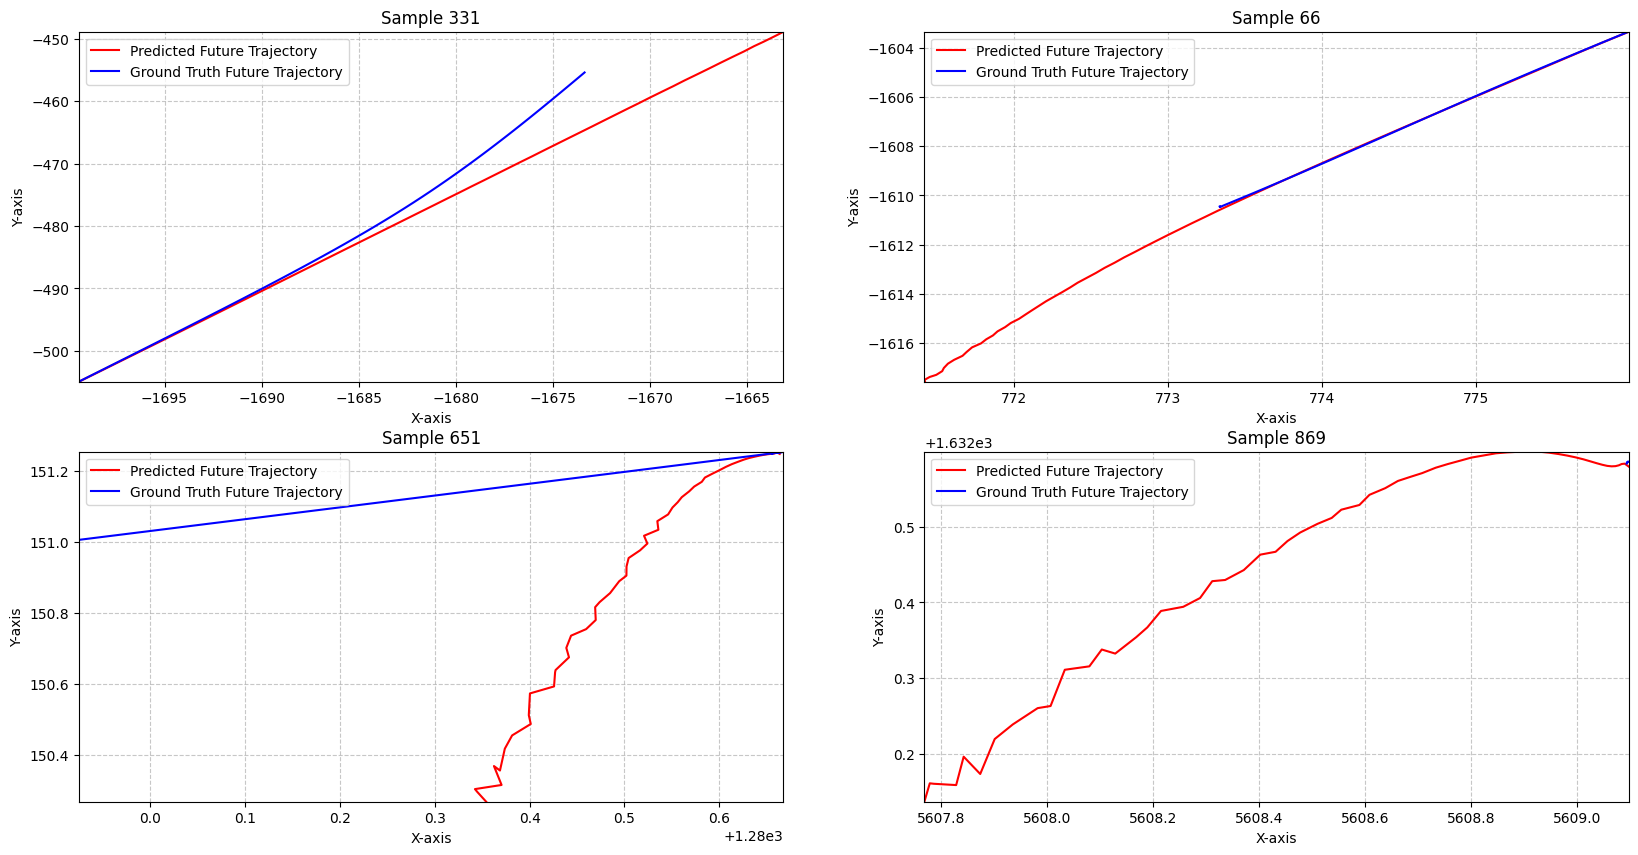

In [100]:
model.load_state_dict(torch.load("best_model.pt"))
model.eval()

# randomly select 4 samples from the validation set
random_indices = random.sample(range(len(val_dataset)), 4)
fig, axes = plt.subplots(2, 2, figsize=(20, 10))
axes = axes.flatten()  # Flatten the array to iterate single axes objects

for i, idx in enumerate(random_indices):
    batch = val_dataset[idx]
    batch = batch.to(device)
    pred = model(batch)
    gt = torch.stack(torch.split(batch.y, 60, dim=0), dim=0)

    pred = pred * batch.scale.view(-1, 1, 1) + batch.origin.unsqueeze(1)
    gt = torch.stack(torch.split(batch.y, 60, dim=0), dim=0) * batch.scale.view(-1, 1, 1) + batch.origin.unsqueeze(1)

    pred = pred.detach().cpu().numpy()
    gt = gt.detach().cpu().numpy()

    # Plot the trajectory using the i-th axis
    plot_trajectory(axes[i], pred, gt, title=f"Sample {idx}")

plt.show()

#### Output your predictions of the best model on the test set

In [81]:
test_dataset = TrajectoryDatasetTest(test_data, scale=scale)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False,
                         collate_fn=lambda xs: Batch.from_data_list(xs))

best_model = torch.load("best_model.pt")
#model = LinearRegressionModel().to(device)
# model = MLP(50 * 50 * 6, 60 * 2).to(device)
model = LSTMWithRelativeTimeAttention().to(device)

model.load_state_dict(best_model)
model.eval()

pred_list = []
with torch.no_grad():
    for batch in test_loader:
        batch = batch.to(device)
        pred_norm = model(batch)
        
        # Reshape the prediction to (N, 60, 2)
        pred = pred_norm * batch.scale.view(-1,1,1) + batch.origin.unsqueeze(1)
        pred_list.append(pred.cpu().numpy())
pred_list = np.concatenate(pred_list, axis=0)  # (N,60,2)
pred_output = pred_list.reshape(-1, 2)  # (N*60, 2)
output_df = pd.DataFrame(pred_output, columns=['x', 'y'])
output_df.index.name = 'index'
output_df.to_csv('submission.csv', index=True)

## Step 4: Summarize your experiments and results in table and figures in the submitted PDF file for Question 3 Problem A

## Step 5: Analyze the results, identify the issues and plan for the improvement in the submitted PDF file for Question 3 Problem B